In [1]:
%reset

# Develop autoencoder network model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import xarray as xr
import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import layers, losses
from keras.datasets import fashion_mnist
from keras.models import Model
from pathlib import Path

In [3]:
root = Path.cwd()
data = root/'data'/'interpolation_datasets'/'rec-interpolation2.nc'
ds = xr.open_dataset(data)
ds

<xarray.Dataset>
Dimensions:        (y: 707, x: 200, P: 8, V: 4)
Coordinates:
  * y              (y) float64 0.0 0.001 0.002 0.003 ... 0.703 0.704 0.705 0.706
  * x              (x) float64 0.0 0.001 0.002 0.003 ... 0.196 0.197 0.198 0.199
  * P              (P) float64 5.0 10.0 30.0 45.0 60.0 80.0 100.0 120.0
  * V              (V) float64 200.0 300.0 400.0 500.0
Data variables:
    potential (V)  (V, P, y, x) float64 ...
    Ne (#/m^-3)    (V, P, y, x) float64 ...
    Ar+ (#/m^-3)   (V, P, y, x) float64 ...
    Nm (#/m^-3)    (V, P, y, x) float64 ...
    Te (eV)        (V, P, y, x) float64 ...

In [4]:
vars = list(ds.data_vars)
vars

['potential (V)', 'Ne (#/m^-3)', 'Ar+ (#/m^-3)', 'Nm (#/m^-3)', 'Te (eV)']

### Process dataset for training

In [5]:
def scale_np(array, var):
    global scaler_dict
    
    max = np.nanmax(array)
    min = np.nanmin(array) 

    scaler_dict[var] = (min, max)

    return (array - min) / (max - min)

In [6]:
scaler_dict = {}

In [7]:
data = np.nan_to_num(np.stack([scale_np(ds[var].values, var) for var in vars]))
data.shape

(5, 4, 8, 707, 200)

In [8]:
data = np.moveaxis(data, 0, 4)
data.shape

(4, 8, 707, 200, 5)

In [9]:
data = data.reshape(32,707,200,5)
data.shape

(32, 707, 200, 5)

### Construct feature vectors

In [10]:
vv, pp = np.meshgrid(ds.V.values, ds.P.values)

In [11]:
features = np.stack([vv.flatten(), pp.flatten()])
features = np.swapaxes(features, 0, 1)
features.shape

(32, 2)

In [119]:
train, test = train_test_split(data, test_size = 1/32, shuffle=True)
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (31, 707, 200, 5)
test shape: (1, 707, 200, 5)


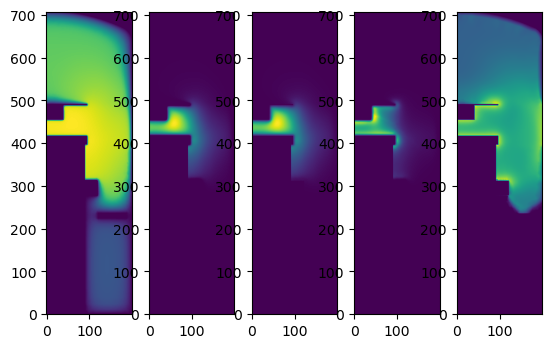

In [120]:
fig, axs = plt.subplots(nrows=1, ncols=5)
for i, ax in enumerate(axs):
    ax.imshow(test[0,:,:,i], origin='lower')

### Create the model

In [140]:
class ConvModel(Model):
  def __init__(self):
    super(ConvModel, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(707, 200, 5)),
      layers.Conv2D(16, 3, activation='relu', padding='same', strides=2),
      # layers.MaxPooling2D((2, 2), padding='same'),
      # layers.Conv2D(16, 3, activation='relu', padding='same', strides=2),
      layers.Conv2D(8, 3, activation='relu', padding='same', strides=2),
      # layers.Conv2D(4, 3, activation='relu', padding='same', strides=2),
      # layers.MaxPooling2D((2, 2), padding='same'),
      ])


    self.decoder = tf.keras.Sequential([
      # layers.UpSampling2D((2, 2)),
      # layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      # layers.Conv2DTranspose(4, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      # layers.UpSampling2D((2, 2)),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(5, kernel_size=3, activation='relu', padding='same'),
      # layers.Cropping2D(cropping=((0, 5), (0, 0)))
      layers.Cropping2D(cropping=((0, 1), (0, 0)))
      ])
    

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [104]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=5,
    decay_rate=0.9
)

In [141]:
autoencoder = ConvModel()
opt = tf.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [142]:
autoencoder.fit(train, train,
                epochs=200,
                shuffle=True,
                validation_data=(test, test),
                callbacks=[early_stop]
                )

Epoch 1/200


2023-02-02 15:26:50.714101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.0404 - val_loss: 0.0085
Epoch 2/200


2023-02-02 15:26:52.738382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 313ms/step - loss: 0.0398 - val_loss: 0.0083
Epoch 3/200
1/1 [==============================] - 0s 303ms/step - loss: 0.0391 - val_loss: 0.0080
Epoch 4/200
1/1 [==============================] - 0s 345ms/step - loss: 0.0383 - val_loss: 0.0077
Epoch 5/200
1/1 [==============================] - 0s 361ms/step - loss: 0.0374 - val_loss: 0.0074
Epoch 6/200
1/1 [==============================] - 0s 305ms/step - loss: 0.0365 - val_loss: 0.0071
Epoch 7/200
1/1 [==============================] - 0s 299ms/step - loss: 0.0355 - val_loss: 0.0068
Epoch 8/200
1/1 [==============================] - 0s 310ms/step - loss: 0.0344 - val_loss: 0.0065
Epoch 9/200
1/1 [==============================] - 0s 260ms/step - loss: 0.0333 - val_loss: 0.0062
Epoch 10/200
1/1 [==============================] - 0s 271ms/step - loss: 0.0320 - val_loss: 0.0059
Epoch 11/200
1/1 [==============================] - 0s 295ms/step - loss: 0.0306 - val_loss: 0.0056
Epoch 12/200
1/1 [==

In [146]:
autoencoder.summary()

Model: "conv_model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_36 (Sequential)  (None, 177, 50, 8)        1896      
                                                                 
 sequential_37 (Sequential)  (None, 707, 200, 5)       2693      
                                                                 
Total params: 4,589
Trainable params: 4,589
Non-trainable params: 0
_________________________________________________________________


In [147]:
autoencoder.encoder.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 354, 100, 16)      736       
                                                                 
 conv2d_75 (Conv2D)          (None, 177, 50, 8)        1160      
                                                                 
Total params: 1,896
Trainable params: 1,896
Non-trainable params: 0
_________________________________________________________________


In [148]:
autoencoder.decoder.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_49 (Conv2D  (None, 354, 100, 16)     1168      
 Transpose)                                                      
                                                                 
 conv2d_transpose_50 (Conv2D  (None, 708, 200, 8)      1160      
 Transpose)                                                      
                                                                 
 conv2d_76 (Conv2D)          (None, 708, 200, 5)       365       
                                                                 
 cropping2d_18 (Cropping2D)  (None, 707, 200, 5)       0         
                                                                 
Total params: 2,693
Trainable params: 2,693
Non-trainable params: 0
_________________________________________________________________


In [17]:
test.shape

(1, 707, 200, 5)

In [18]:
train[0].shape

(707, 200, 5)

In [143]:
encoded = autoencoder.encoder(test).numpy()
decoded = autoencoder.decoder(encoded).numpy()
cbar_ranges = [(test[0,:,:,i].min(), test[0,:,:,i].max()) for i in range(5)]
cbar_ranges

[(0.0, 0.2783770984424963),
 (0.0, 0.24272478606854553),
 (0.0, 0.24274030486978124),
 (0.0, 0.08462580969510108),
 (0.0, 0.37533674053233196)]

In [20]:
decoded.shape

(1, 707, 200, 5)

In [21]:
decoded[0,:,:,0].shape

(707, 200)

In [150]:
import matplotlib.patches as pat
def draw_apparatus(ax):
    def edge_unit_conv(edges):
        u = 1e-1 # unit conv. mm -> cm
        return [(xy[0]*u,xy[1]*u) for xy in edges]
    
    pt_colors = {'fc':'white', 'ec':'black'}
    
    edges = [(0,453), (0,489), (95,489), (95,487), (40,487), (40,453)]
    patch_top = pat.Polygon(xy=edge_unit_conv(edges), fc=pt_colors['fc'], ec=pt_colors['ec'])
    ax.add_patch(patch_top)
    
    edges = [(0,0), (0,415), (95,415), (95,395), (90,395), (90,310), (120,310), (120,277), (90,277), (90,0)]
    patch_bottom = pat.Polygon(xy=edge_unit_conv(edges), fc=pt_colors['fc'], ec=pt_colors['ec'])
    ax.add_patch(patch_bottom)
    
    edges = [(122,224), (122,234), (185,234), (185,224)]
    patch_float = pat.Polygon(xy=edge_unit_conv(edges), fc=pt_colors['fc'], ec=pt_colors['ec'])
    ax.add_patch(patch_float)

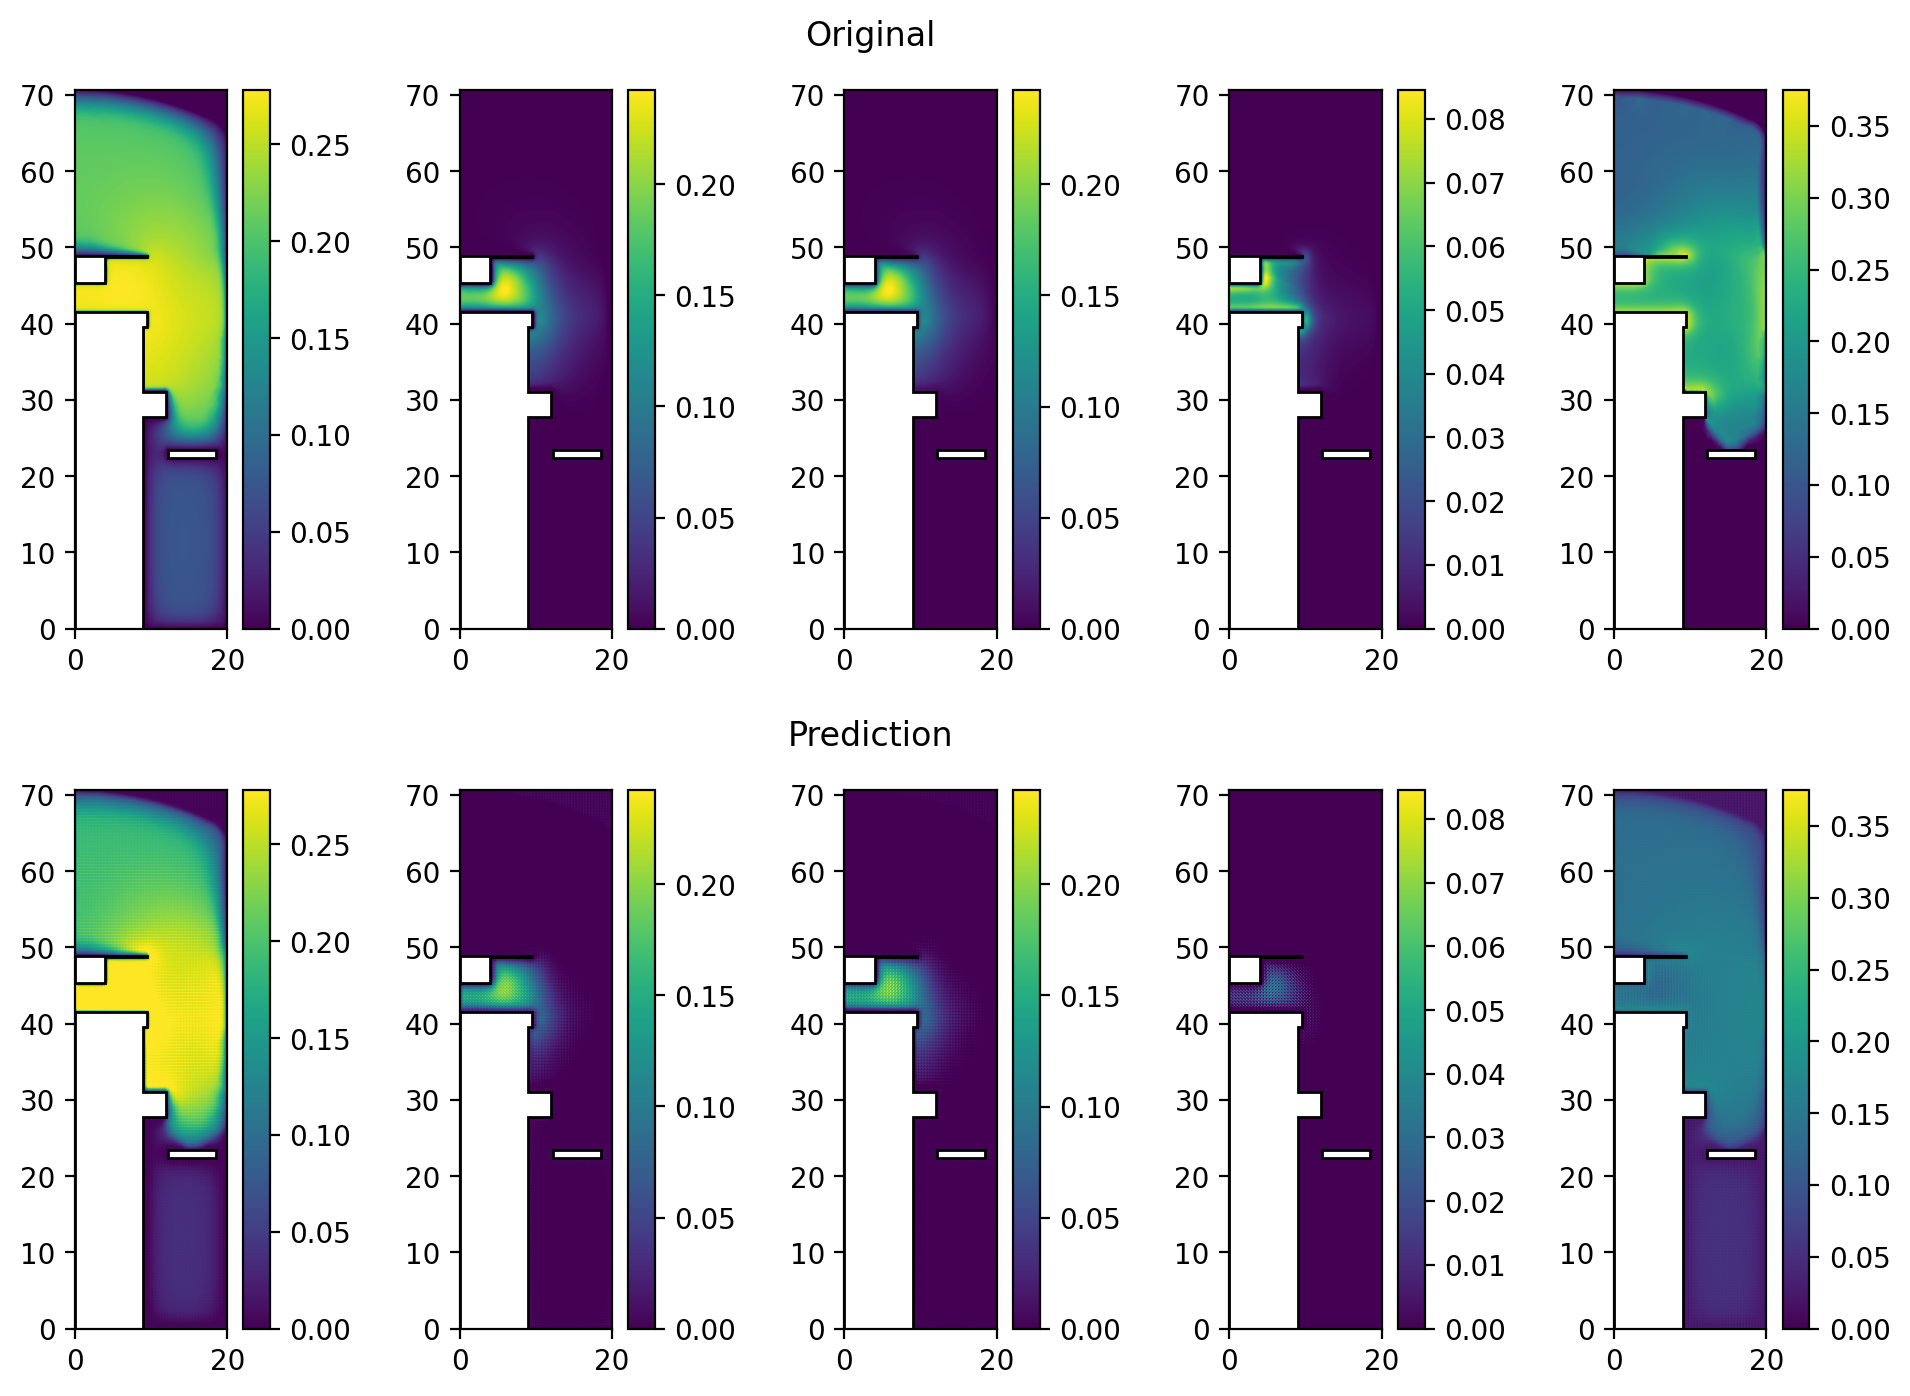

In [153]:
fig = plt.figure(figsize=(12, 7), dpi=200)
subfigs = fig.subfigures(nrows=2)

axs1 = subfigs[0].subplots(nrows=1, ncols=5)
axs2 = subfigs[1].subplots(nrows=1, ncols=5)

subfigs[1].suptitle('Prediction')
subfigs[0].suptitle('Original')

for i in range(5):
    org = axs1[i].imshow(test[0,:,:,i], origin='lower', extent=[0,20,0, 70.7])
    draw_apparatus(axs1[i])
    plt.colorbar(org)
    rec = axs2[i].imshow(decoded[0,:,:,i], origin='lower', extent=[0,20,0, 70.7],
                         vmin=cbar_ranges[i][0], vmax=cbar_ranges[i][1])
    draw_apparatus(axs2[i])
    plt.colorbar(rec)

In [149]:
from sklearn.metrics import mean_squared_error
for i in range(5):
    mse = mean_squared_error(decoded[0,:,:,i], test[0,:,:,i])
    print(mse)

0.0004548454817035874
0.00015369083434325714
0.00014686966931901554
7.530354301766212e-05
0.0027338317639545528


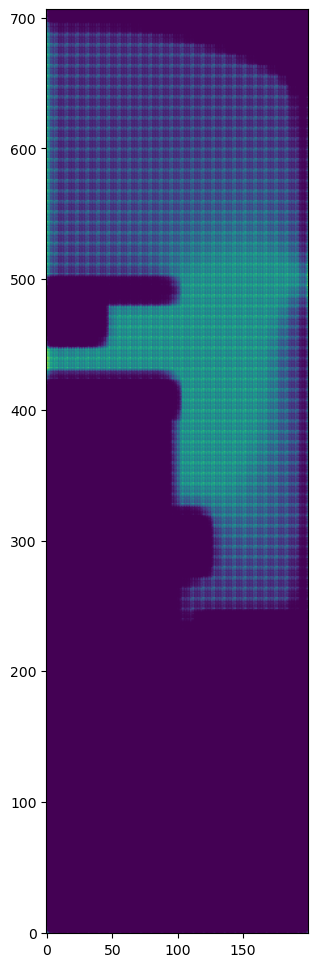

In [23]:
fig, ax = plt.subplots(figsize=(48,12))
plt.imshow(decoded[0,:,:,1], origin='lower')

Arrays will be encoded, and labels appended to the latent space representation before decoding

## Process dataset to numpy arrays for model training



*   Convert Dataset variable to numpy
*   Convert NaNs to 0
*   Reduce dimensions of V and P



In [24]:
npds = ds['potential (V)'].to_numpy()
npds = np.nan_to_num(npds)
npds.shape

(4, 8, 707, 200)

Dataset has a shape of (5, 4, 8, 707, 200) corresponding to (variables, voltage, pressure, y, x)

In [25]:
npds = npds.reshape((32, 707, 200))
npds.shape

(32, 707, 200)

In [26]:
np.nanmax(npds)

205.71708513606058

Scale the data using minmax scaling

$x' = \frac{x - x_{min}}{x_{max} - x_{min}}$

In [27]:
scaled_ds = (npds - np.nanmin(npds)) / (np.nanmax(npds) - np.nanmin(npds))
print(np.nanmin(scaled_ds))
print(np.nanmax(scaled_ds))

0.0
1.0


Split data into train and test sets 

In [28]:
v_train, v_test = train_test_split(scaled_ds, test_size = 1/32)
print(f'train shape: {v_train.shape}')
print(f'test shape: {v_test.shape}')

train shape: (31, 707, 200)
test shape: (1, 707, 200)


In [29]:
v_train = v_train[..., tf.newaxis]
v_test = v_test[..., tf.newaxis]

print(v_train.shape)

(31, 707, 200, 1)


Initial model with sequential layers for encode and decode

In [30]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(128, activation='sigmoid'),
      layers.Dense(256, activation='sigmoid'),
      layers.Dense(707*200, activation='sigmoid'),
      layers.Reshape((707, 200))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

Autoencoder with convolutional layers

In [31]:
class ConvModel(Model):
  def __init__(self):
    super(ConvModel, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(707, 200, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])


    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'),
      layers.Cropping2D(cropping=((1, 0), (0, 0)))])
    

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [32]:
# autoencoder = Autoencoder(latent_dim)
autoencoder = ConvModel()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [33]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 354, 100, 16)      160       
                                                                 
 conv2d_5 (Conv2D)           (None, 177, 50, 8)        1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [34]:
autoencoder.decoder.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
input_img = keras.Input(shape=(707, 200, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

In [ ]:
autoencoder.fit(v_train, v_train,
                epochs=100,
                shuffle=True,
                validation_data=(v_test, v_test))

In [ ]:
encoded_imgs = autoencoder.encoder(v_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
decoded_imgs.reshape(707,200)

In [ ]:
v_test.max()

In [ ]:
n = 1
fig = plt.figure(figsize=(6, 8))
fig.suptitle('Autoencoder predicting potential (V)')
for i in range(n):
  # display original
  ax = plt.subplot(n, 2, i + 1)
  im = plt.imshow(v_test[0,:,:,0], origin='lower', vmin=0, vmax = 0.4)
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(n, 2, i + 1 + n)
  plt.imshow(decoded_imgs[0,:,:,0], origin='lower', vmin=0, vmax = 0.4)
  plt.title("reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
fig.colorbar(im)
plt.show()

In [ ]:
fig.savefig('/content/drive/MyDrive/2d-discharge-nn/potentialtest.png', bbox_inches='tight')